In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy.linalg as LA

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['text.usetex'] = True

In [22]:
fp = '../Synthetic/farinotti_corrected/hysteresis/smoothBed_SS_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '3000a' in file])
xarrays = []

for file in files[:11]:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

SmoothBed_SS_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.00, 0.01),  name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26),  name='Delta_MB'))
    
SmoothBed_SS_IC['z_s'] = SmoothBed_SS_IC.z_s.where((SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b) != 10., SmoothBed_SS_IC.z_b)
SmoothBed_SS_IC["H"]   = SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b

In [23]:
fp = '../Synthetic/farinotti_corrected/hysteresis/observed_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '3000a' in file])
xarrays = []

for file in files[:11]:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

Observed_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.00, 0.01), name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26), name='Delta_MB'))

Observed_IC['z_s'] = Observed_IC.z_s.where((Observed_IC.z_s - Observed_IC.z_b) != 10., Observed_IC.z_b)
Observed_IC["H"]   = Observed_IC.z_s - Observed_IC.z_b

In [24]:
OIC_vol = Observed_IC.H.integrate("x")     / Observed_IC.H.sel(t=1).integrate("x")
SIC_vol = SmoothBed_SS_IC.H.integrate("x") / Observed_IC.H.sel(t=1).integrate("x")

In [25]:
############################################################
# For Seting up the colorbar: 
#    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
############################################################

colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(Observed_IC.Delta_MB), vmax=np.max(Observed_IC.Delta_MB))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(Observed_IC.Delta_MB)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (Observed_IC.Delta_MB[1] - Observed_IC.Delta_MB[0])/2.0
boundaries = np.linspace(Observed_IC.Delta_MB[0] - halfdist, 
                         Observed_IC.Delta_MB[-1] + halfdist, 
                         len(Observed_IC.Delta_MB) + 1)


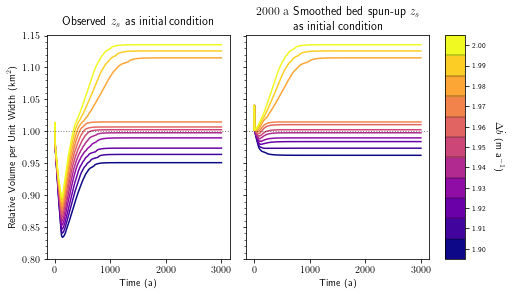

In [37]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7, 4), constrained_layout=True)


for delta_mb in Observed_IC.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    ax[0].plot(OIC_vol.t[1:], 
               OIC_vol.sel(Delta_MB=delta_mb)[1:],
               color=color)
    
    ax[1].plot(SIC_vol.t, 
               SIC_vol.sel(Delta_MB=delta_mb), 
               color=color,
               label=delta_mb.values)

ax[0].axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)
ax[1].axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=OIC_vol.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7) 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0.8, 1.20, 0.05)
minor_ticks = np.arange(0.8, 1.15, 0.01)

ax[0].set_yticks(major_ticks)
ax[0].set_yticks(minor_ticks, minor=True)
ax[1].set_yticks(major_ticks)
ax[1].set_yticks(minor_ticks, minor=True)

ax[0].set_title(r'\begin{center} Observed $z_s$ as initial condition \end{center}',pad = 10.0)
ax[1].set_title(r'\begin{center} $2000 \; \rm{a}$ Smoothed bed spun-up $z_s$ \\ as initial condition \end{center}',pad = 20.0)

ax[0].set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax[0].set_xlabel('Time (a)')
ax[1].set_xlabel('Time (a)')

fig.savefig('../plots/farinotti_corrected/hysteresis/Vol_1.9--2.0.png', dpi=400, bbox_inches='tight', facecolor='w')

In [45]:
(OIC_vol.isel(t=-1) - SIC_vol.isel(t=-1)).values.min()

-0.011543135294567075

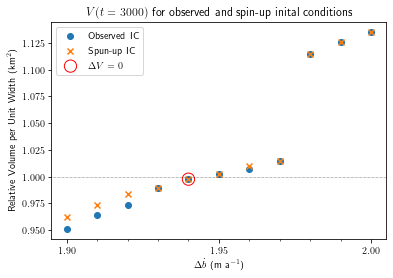

In [47]:
fig, ax = plt.subplots(1,1)


ax.scatter(OIC_vol.Delta_MB, OIC_vol.isel(t=-1),label='Observed IC')
ax.scatter(SIC_vol.Delta_MB, SIC_vol.isel(t=-1),label='Spun-up  IC',marker='x')

ax.legend()

ax.scatter(OIC_vol.isel(Delta_MB=4).Delta_MB, 
           OIC_vol.isel(Delta_MB=4).isel(t=-1), 
           s=150, edgecolors='r', facecolor='None',
           label='$\Delta V = 0$')


ax.axhline(1.0, ls=':', c='k', lw=0.5)

ax.set_title( '$V(t=3000)$ for observed and spin-up inital conditions')
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('$\Delta \dot b$ (m a$^{-1}$)')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(1.90, 2.00, 0.05)
minor_ticks = np.arange(1.90, 2.00, 0.01)

ax.set_xticks(major_ticks);
ax.set_xticks(minor_ticks, minor=True);


ax.legend()

fig.savefig('../plots/farinotti_corrected/hysteresis/V(t=3000).png', dpi=400, bbox_inches='tight', facecolor='w')

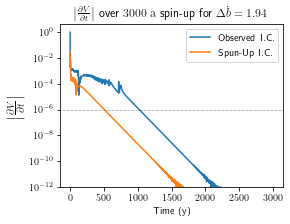

In [50]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(OIC_vol.t, np.abs(OIC_vol.isel(Delta_MB=4).differentiate('t')), label='Observed I.C.')
ax.plot(SIC_vol.t, np.abs(SIC_vol.isel(Delta_MB=4).differentiate('t')), label='Spun-Up I.C.')
ax.legend()

ax.set_title( r'$\left| \frac{\partial V}{\partial t} \right|$ over $3000 \; \rm{a}$ spin-up for $\Delta \dot b = 1.94$')
ax.set_ylabel(r'$\left| \frac{\partial V}{\partial t} \right|$', fontsize='x-large')
ax.set_xlabel('Time (a)')

ax.axhline(10e-7, ls=':', c='k', lw=0.5)
ax.set_yscale('log')
ax.set_ylim(10e-13, None)
fig.savefig('../plots/farinotti_corrected/hysteresis/dVdt_delta_MB=1.93.png', dpi=400, bbox_inches='tight', facecolor='w')

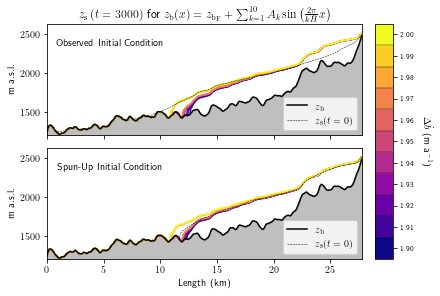

In [48]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True, constrained_layout=True)


for delta_mb in Observed_IC.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    
    ax[0].plot(Observed_IC.x/1000., 
               Observed_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s,
               color=color)
    
    ax[1].plot(SmoothBed_SS_IC.x/1000., 
               SmoothBed_SS_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s,
               color=color)
    
    
ax[0].plot(Observed_IC.x/1000.,      Observed_IC.isel(t=-1,Delta_MB=0).z_b, 'k', label=r'$z_{\rm b}$')
ax[0].plot(Observed_IC.x/1000.,      Observed_IC.isel(t=1,Delta_MB=0).z_s, c='k', ls='--', lw=0.5, label=r'$z_{\rm s}(t=0)$')
ax[0].fill_between(Observed_IC.x/1000., Observed_IC.isel(t=0,Delta_MB=0).z_b, color='gray', alpha=0.5)
ax[0].set_xlim(0,np.max(Observed_IC.x)/1000.)
ax[0].set_ylim(1200, None)
ax[0].set_ylabel('m a.s.l.')

ax[1].plot(SmoothBed_SS_IC.x/1000.,  SmoothBed_SS_IC.isel(t=-1,Delta_MB=0).z_b, 'k', label=r'$z_{\rm b}$')
ax[1].plot(SmoothBed_SS_IC.x/1000.,  SmoothBed_SS_IC.isel(t=0, Delta_MB=0).z_s, c='k', ls='--', lw=0.5, label=r'$z_{\rm s}(t=0)$')
ax[1].fill_between(Observed_IC.x/1000., Observed_IC.isel(t=0,Delta_MB=0).z_b, color='gray', alpha=0.5)
ax[1].set_xlabel('Length (km)')
ax[1].set_ylabel('m a.s.l.')

ax[0].legend(loc=4)
ax[1].legend(loc=4)

cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=OIC_vol.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7) 


ax[0].set_title(r'$z_{\rm s} \left( t=3000 \right)$ for $z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
            
ax[0].text(0.20,0.8,
             'Observed Initial Condition',
             transform=ax[0].transAxes, horizontalalignment='center')

ax[1].text(0.20,0.8,
             'Spun-Up Initial Condition',
             transform=ax[1].transAxes, horizontalalignment='center')

#fig.tight_layout()
fig.savefig('../plots/farinotti_corrected/hysteresis/Final_Zs_1.90--2.00.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
import glob 

pertb = np.loadtxt('../Data/Topography/pert_R_0.01_harmonics_1-10.dat')[:,1]
reff  = np.loadtxt('../Data/Topography/REF_BedTopo_2.dat')[:,1]

In [ ]:
f, t, Sxx = signal.spectrogram(pertb-reff, fs=1/100,  nperseg=2, noverlap=1, detrend=None, scaling='spectrum')

plt.pcolormesh(t/1000., f,  10*np.log10(np.sqrt(Sxx)), shading='auto')

plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [ ]:
plt.plot(pertb-reff)

In [ ]:
f, Pxx_den = signal.periodogram(pertb-reff, fs=1/100, detrend=None, scaling='spectrum')

plt.plot(f,np.sqrt(Pxx_den))

In [ ]:
for bed_fp in beds:
    plt.plot(np.loadtxt(bed_fp)[:,0], np.loadtxt(bed_fp)[:,1], lw=1)
    
# #plt.plot(SmoothBed_SS_IC.x,  SmoothBed_SS_IC.isel(t=-1,Delta_MB=0).z_b, 'k')

# plt.savefig('/Users/andrewnolan/Desktop/Test.png', dpi=600, bbox_inches='tight', facecolor='w')

In [ ]:
from scipy import signal

In [ ]:
SmoothBed_SS_IC.isel(t=-1,Delta_MB=0).z_b - np.loadtxt(bed_fp)[:,1]

In [ ]:
np.loadtxt('../Data/Topography/pert_R_0.01_harmonics_1-10.dat')[:,1] -  np.loadtxt(bed_fp)[:,1]

In [51]:
1/(2*100)

0.005

In [54]:
1/(2*200)

0.0025